In [1]:
import sys 
sys.path.append('../scripts/')
from kf import *   #誤差楕円を描くのに利用

In [2]:
def draw(xs, ms, zlist, Rs):  ###graphslam4draw
    ##世界の描画##
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111) 
    ax.set_aspect('equal')
    ax.set_xlim(-5,5)
    ax.set_ylim(-5,5) 
    ax.set_xlabel("X",fontsize=10) 
    ax.set_ylabel("Y",fontsize=10)
    
    ##軌跡の描画##
    poses = [xs[s] for s in range(len(xs))]
    ax.scatter([e[0] for e in poses], [e[1] for e in poses], s=5, marker=".", color="black")
    ax.plot([e[0] for e in poses], [e[1] for e in poses], linewidth=0.5, color="black")

    ##センサ値の描画##
    for t in range(1,len(xs)):
        if t not in zlist: continue
            
        for obs in zlist[t]:
            x, y, theta = xs[t]
            ell, phi = obs[1]
            mx = x + ell*math.cos(theta + phi)
            my = y + ell*math.sin(theta + phi)
            ax.plot([x,mx], [y,my], color="pink", alpha=0.5)
     #       ax.add_patch( sigma_ellipse(np.array([mx, my]), Qs[(t, obs[0])], 1) ) #追加
        
    ##ランドマークの推定位置の描画## 
    ax.scatter([e[0] for e in ms], [e[1] for e in ms], s=10, marker="*", color="blue")
    print(ms)
    
    ##R_tの描画## 
    for t in range(1,t_end+1):
        ax.add_patch( sigma_ellipse(xs[t], Rs[t], 10) )
    
    ##描画実行##
    plt.show()

In [3]:
###データの読み込み###
delta = 0.0
xs = {}     #軌跡のデータ（ステップ数をキーにして姿勢を保存）
zlist = {} #センサ値のデータ（ステップ数をキーにして、さらにその中にランドマークのIDとセンサ値をタプルで保存）
us = {}    #制御入力のデータ（ステップ数をキーにして保存）

with open("log.txt") as f:
    for line in f.readlines():
        tmp = line.rstrip().split()
        
        step = int(tmp[1])
        if tmp[0] == "delta":
            delta = float(tmp[1])
        elif tmp[0] == "x": #姿勢のレコードの場合
            xs[step] = np.array([float(tmp[2]), float(tmp[3]), float(tmp[4])]).T
        elif tmp[0] == "z": #センサ値のレコードの場合
            if step not in zlist:  #まだ辞書が空の時は空の辞書を作る
                zlist[step] = []
            zlist[step].append((int(tmp[2]), np.array([float(tmp[3]), float(tmp[4])]).T))
        elif tmp[0] == "u": #制御入力の場合
            us[step] = np.array([float(tmp[2]), float(tmp[3])]).T
            
zlist

{0: [(1, array([ 3.6709724, -0.9666622])),
  (2, array([3.88288066, 0.7912208 ])),
  (4, array([1.41096057, 0.80728486]))],
 1: [(2, array([3.52877923, 0.61258389])),
  (4, array([1.24873242, 0.70026028]))],
 2: [(2, array([3.975502  , 0.63289778])),
  (4, array([1.1783655 , 0.80437791]))],
 3: [(2, array([3.89229753, 0.54243267])),
  (4, array([1.05189286, 0.94085451]))],
 4: [(2, array([3.43775824, 0.50546541]))],
 5: [(2, array([2.6815307 , 0.61813163]))],
 6: [(2, array([2.63337292, 0.68595473]))],
 7: [(2, array([3.08328921, 0.66940921]))],
 8: [(2, array([2.9084739 , 0.63528832]))],
 9: [(2, array([2.5769141 , 0.54427032]))],
 10: [(2, array([2.18395821, 0.51959031]))],
 11: [(2, array([2.35334313, 0.58104182]))],
 12: [(2, array([2.05533444, 0.47149149]))],
 13: [(2, array([2.35857919, 0.53212499]))],
 14: [(2, array([1.72099253, 0.47563392]))],
 15: [(2, array([1.37816051, 0.38207986]))],
 16: [(2, array([1.60312198, 0.4280213 ]))],
 17: [(2, array([1.25032557, 0.45494044]))],


In [4]:
##空の精度行列と一次の項のベクトルの準備## 
t_end = len(xs) - 1 #step数（数式中のT）

##観測されたランドマークのリスト（精度行列に設けるもの）のセット##
observed_landmarks = set()
for t in range(len(xs)):
    if t not in zlist: continue

    for obs in zlist[t]:
        observed_landmarks.add(obs[0])

##精度行列の次元を求めて精度行列と一次の項のベクトルの初期化##
dim = (t_end + 1)*3 + len(observed_landmarks)*2
Omega = np.zeros((dim, dim))
xi = np.zeros((dim, 1))

##確認##
print(t_end)                           #終了時刻
print(observed_landmarks) #観測されたランドマークのID
print(Omega)                        #精度行列
print(xi)                                  #一次の項のベクトル

91
{0, 1, 2, 3, 4, 5}
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]


In [5]:
mxs, mys = {}, {} #ランドマークごとにx座標を貯める辞書
for j in observed_landmarks: mxs[j], mys[j] = [], [] #ランドマークごとに座標のリストを初期化

for t in range(len(xs)):
    if t not in zlist: continue  #センサ値のないステップは飛ばす
            
    for obs in zlist[t]:             #センサ値ごとに地図上の位置を計算
        x, y, theta = xs[t]         #デッドレコニング上の座標
        ell, phi = obs[1]            #センサ値
        j = obs[0]                      #ランドマークのID
        mx = x + ell*math.cos(theta + phi)    #ランドマークの座標
        my = y + ell*math.sin(theta + phi)    #ランドマークの座標
        
        mxs[j].append(mx)     #計算した座標をリストに加える
        mys[j].append(my)
        
mx_avg, my_avg = {}, {}
hat_ms = []
for j in observed_landmarks:  #ランドマークごとに平均値を出す
    mx_avg[j] = sum(mxs[j])/len(mxs[j])
    my_avg[j] = sum(mys[j])/len(mys[j])
    hat_ms.append(np.array([mx_avg[j], my_avg[j]]).T)
    
hat_xs = xs  #姿勢の初期値はxsをそのまま使う
hat_ms = hat_ms

print(hat_ms)

[array([-3.42659338, -0.85291848]), array([4.49143722, 0.20890647]), array([1.6762631 , 3.42820037]), array([-1.32403143,  2.979781  ]), array([1.22772133, 1.30724536]), array([-0.64114582, -2.71849748])]


In [6]:
##Ω_0を作る## 
alpha = 0.001
Sigma_0 = np.diag([0.001**2, 0.001**2, 0.001**2])

Omega_0 = np.linalg.inv(Sigma_0) #3x3の精度行列としてΩ0を作る
xi_0 = Omega_0.dot(hat_xs[0])

print("Ω0 = ", Omega_0)
print("ξ0 =", xi_0)

Ω0 =  [[1000000.       0.       0.]
 [      0. 1000000.       0.]
 [      0.       0. 1000000.]]
ξ0 = [0. 0. 0.]


In [7]:
##Ωxx,ξxxを作る##  
motion_noise_stds = {"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}

def R(t): #R_tを返す
    theta = hat_xs[t][2]
    nu, omega = us[t]
    if abs(omega) < 1e-5: omega = 1e-5 #ゼロにすると式が変わるので避ける
    if abs(nu) < 1e-5:         nu = 1e-5
        
    st, ct = math.sin(theta), math.cos(theta)
    stw, ctw = math.sin(theta + omega*delta), math.cos(theta + omega*delta)
    A = np.array([[(stw - st)/omega,    -nu/(omega**2)*(stw - st) + nu/omega*delta*ctw],
                                 [(-ctw + ct)/omega, -nu/(omega**2)*(-ctw + ct) + nu/omega*delta*stw],
                                 [0,                                delta]] )
    M = np.diag(
        [motion_noise_stds["nn"]**2*abs(nu)/delta +motion_noise_stds["no"]**2*abs(omega)/delta,
             motion_noise_stds["on"]**2*abs(nu)/delta + motion_noise_stds["oo"]**2*abs(omega)/delta]
    )
    return A.dot(M).dot(A.T) + np.diag([0.01**2, 0.01**2, 0.01**2]) #xyθ方向に誤差を混ぜておく

def F(t): #F_x_{t-1}を返す（添字注意）
    F = np.array(np.eye(3))
    x, y, theta = hat_xs[t-1]
    nu, omega = us[t]
    if abs(omega) < 1e-5: omega = 1e-5 #ゼロにすると式が変わるので避ける
    if abs(nu) < 1e-5:         nu = 1e-5
    
    F[0, 2] = nu / omega * (math.cos(delta + omega * delta) - math.cos(theta))
    F[1, 2] = nu / omega * (math.sin(delta + omega * delta) - math.sin(theta))
        
    return F

##必要な行列を先に計算##
Rs, Fs, Rinvs = {}, {}, {}
for t in range(1, t_end+1):
    Rs[t] = R(t)
    Rinvs[t] = np.linalg.inv(Rs[t])
    Fs[t-1] = F(t)
    
##各x_{t-1}, x_tペアの精度行列と一次の項のベクトルを作る##
Omxx_ul, Omxx_ur, Omxx_bl, Omxx_br = {}, {}, {}, {} #x_{t-1}とx_tに対する精度行列を保管する辞書
xixx_u, xixx_b = {}, {}

for t in range(1, t_end+1):
    Omxx_ul[(t-1, t)] = Fs[t-1].T.dot(Rinvs[t]).dot(Fs[t-1])
    Omxx_ur[(t-1, t)] = -Fs[t-1].T.dot(Rinvs[t])
    Omxx_bl[(t-1, t)] = -Rinvs[t].dot(Fs[t-1].T)
    Omxx_br[(t-1, t)] = Rinvs[t]
    
    nu, omega = us[t]
    xixx_b[(t-1, t)] = Rinvs[t].dot(IdealRobot.state_transition(nu, omega, delta, xs[t-1]) - Fs[t-1].dot(xs[t-1])) #下の3行から計算
    xixx_u[(t-1, t)] = - Fs[t-1].dot(xixx_b[(t-1, t)]) #上の三行

In [8]:
distance_dev_rate=0.14  ###graphslam4obs###
direction_dev=0.05

def HxHmQ(t, j):
    x, y, _ = hat_xs[t]
    mx, my = hat_ms[j]
    lxm = math.sqrt((x-mx)**2 + (y-my)**2)
    
    ##Qの計算##
    Q = np.diag(np.array([(distance_dev_rate*lxm)**2, direction_dev**2]))
    Qinv = np.linalg.inv(Q)
            
    ##Hの計算##
    Hx = np.array([[(x - mx)/lxm, (y - my)/lxm, 0.0],
                              [(my - y)/(lxm**2), (x - mx)/(lxm**2), -1.0]])
    Hm = - Hx[0:2, 0:2]
    return Hx, Hm, Q, Qinv

Omxm_ul, Omxm_ur, Omxm_bl, Omxm_br = {}, {}, {}, {}
xixm_u, xixm_b = {}, {}
    
for t in range(1, t_end+1):
    if t not in zlist:          continue
    
    for obs in zlist[t]:
        j, z = obs
        Hx, Hm, Q, Qinv = HxHmQ(t, j)
        
        Omxm_ul[(t, j)] = Hx.T.dot(Qinv).dot(Hx)
        Omxm_ur[(t, j)] = Hx.T.dot(Qinv).dot(Hm)
        Omxm_bl[(t, j)] = Hm.T.dot(Qinv).dot(Hx)
        Omxm_br[(t, j)] = Hm.T.dot(Qinv).dot(Hm)
        
        tmp = Qinv.dot(Hx.dot(hat_xs[t]) + Hm.dot(hat_ms[j]) + np.array(z) - IdealCamera.relative_polar_pos(hat_xs[t], hat_ms[j]))
        xixm_u[(t, j)] = Hx.T.dot(tmp)
        xixm_b[(t, j)] = Hm.dot(tmp)

In [9]:
Omega = np.zeros((dim, dim))
xi = np.zeros((dim, 1))

Omega[0:3, 0:3] += Omega_0
xi[0:3, 0] += xi_0

for t in range(1, t_end+1):
    Omega[(t-1)*3:t*3, (t-1)*3:t*3] +=  Omxx_ul[(t-1, t)]
    Omega[(t-1)*3:t*3, t*3:(t+1)*3] +=  Omxx_ur[(t-1, t)]
    Omega[t*3:(t+1)*3, (t-1)*3:t*3] +=  Omxx_bl[(t-1, t)]
    Omega[t*3:(t+1)*3, t*3:(t+1)*3] +=  Omxx_br[(t-1, t)]
    
    xi[(t-1)*3:t*3, 0] += xixx_u[(t-1, t)]
    xi[t*3:(t+1)*3, 0] += xixx_b[(t-1, t)]
    
for obs in zlist[t]:
    Omega[t*3:(t+1)*3, ]

[array([-3.42659338, -0.85291848]), array([4.49143722, 0.20890647]), array([1.6762631 , 3.42820037]), array([-1.32403143,  2.979781  ]), array([1.22772133, 1.30724536]), array([-0.64114582, -2.71849748])]


<IPython.core.display.Javascript object>


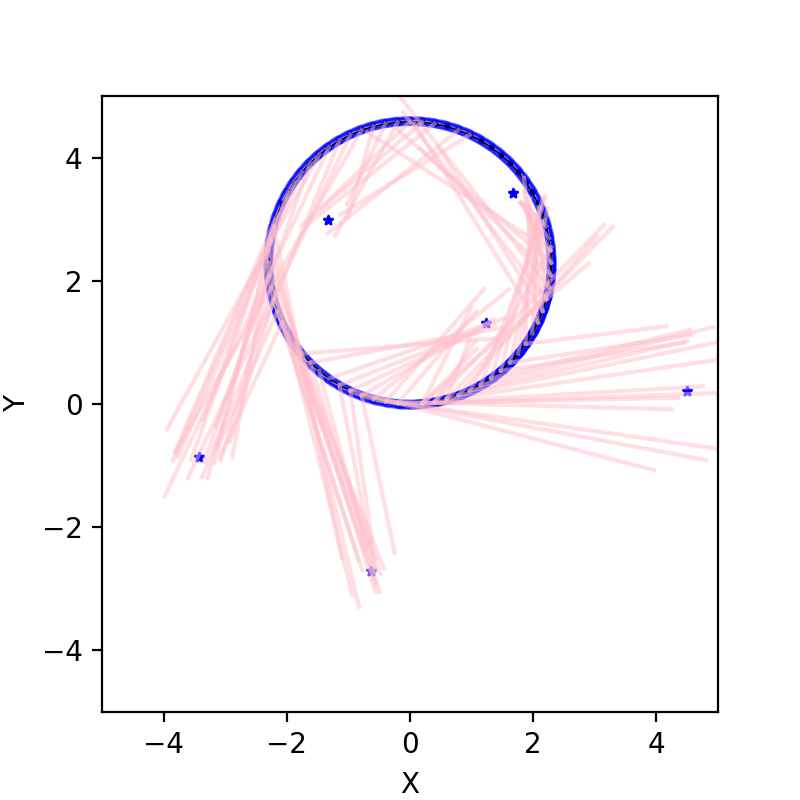

In [10]:
draw(hat_xs, hat_ms, zlist, Rs) ###graphslam4calldraw